In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE HEADER
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [43]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import gc
import warnings 

pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

# Use it to decrease memory use
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Data ingestion

In [45]:
df_news = pd.read_csv("./data/OnlineNewsPopularity.csv")
df_news = reduce_mem_usage(df_news)

m, k = df_news.shape
print("{} x {} table of data:".format(m, k))
display(df_news.head())
print("...")

Mem. usage decreased to  5.52 Mb (70.1% reduction)
39644 x 61 table of data:


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663574,1.0,0.815430,4.0,2.0,1.0,...,0.099976,0.700195,-0.350098,-0.600098,-0.199951,0.50000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604980,1.0,0.791992,3.0,1.0,1.0,...,0.033325,0.700195,-0.118774,-0.125000,-0.099976,0.00000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575195,1.0,0.664062,3.0,1.0,1.0,...,0.099976,1.000000,-0.466553,-0.799805,-0.133301,0.00000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503906,1.0,0.665527,9.0,0.0,1.0,...,0.136353,0.799805,-0.369629,-0.600098,-0.166626,0.00000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415527,1.0,0.541016,19.0,19.0,20.0,...,0.033325,1.000000,-0.220215,-0.500000,-0.049988,0.45459,0.136353,0.045441,0.136353,505


...


In [5]:
# Quick statistical summary of data
df_news.describe(include='all')

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644,39644.0,3.964400e+04,39644.0,3.964400e+04,3.964400e+04,3.964400e+04,39644.0,3.964400e+04,39644.0000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
unique,39644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,http://mashable.com/2014/10/23/wombat-day-aust...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,inf,inf,inf,5.478516e-01,9.960938e-01,6.894531e-01,inf,inf,inf,...,0.095459,0.756836,-0.259521,-0.521973,-0.107544,0.282471,0.071411,0.342041,0.156128,3395.380184
std,NaN,inf,2.113281e+00,inf,inf,inf,inf,inf,3.855469e+00,8.3125,...,0.071289,0.247803,0.127686,0.290283,0.095337,0.324219,0.265381,0.188843,0.226196,11626.950749
min,NaN,8.0,2.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,NaN,164.0,9.000000e+00,246.0,4.709473e-01,1.000000e+00,6.258545e-01,4.0,1.000000e+00,1.0000,...,0.049988,0.600098,-0.328369,-0.700195,-0.125000,0.000000,0.000000,0.166626,0.000000,946.000000
50%,NaN,339.0,1.000000e+01,409.0,5.390625e-01,1.000000e+00,6.904297e-01,8.0,3.000000e+00,1.0000,...,0.099976,0.799805,-0.253418,-0.500000,-0.099976,0.150024,0.000000,0.500000,0.000000,1400.000000
75%,NaN,542.0,1.200000e+01,716.0,6.088867e-01,1.000000e+00,7.543945e-01,14.0,4.000000e+00,4.0000,...,0.099976,1.000000,-0.186890,-0.300049,-0.049988,0.500000,0.150024,0.500000,0.250000,2800.000000


## Exploratory data analysis

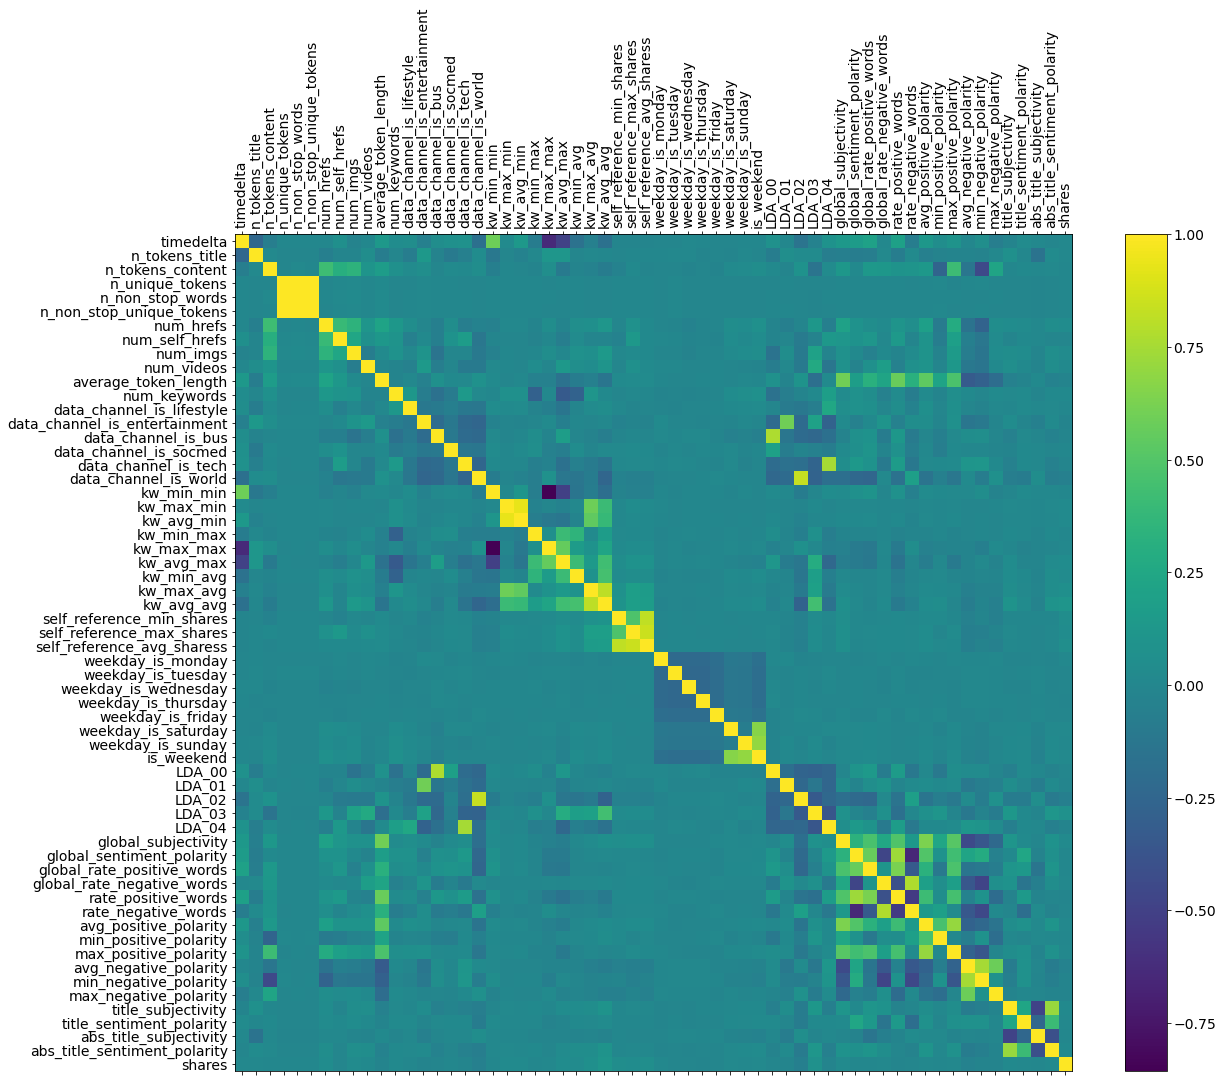

In [47]:
# Removing space character in the feature names
df_news.columns=df_news.columns.str.replace(' ','')

# Plot correlation matrix
df_news = df_news.drop(['url'], axis=1)
f = plt.figure(figsize=(19, 15))
plt.matshow(df_news.corr(), fignum=f.number)
plt.xticks(range(df_news.shape[1]), df_news.columns, fontsize=14, rotation=90)
plt.yticks(range(df_news.shape[1]), df_news.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

It appears that there are a few highly correlated variables (in absolute value). In order to make sure these variables won't introduce any redundancy or bias in our model, we will remove variables with high correlations or that seem redundant.

In [48]:
df_news = df_news.drop(['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',\
                        'kw_min_max', 'kw_avg_max', 'kw_avg_avg', 'weekday_is_monday', 'LDA_00',\
                        'LDA_01', 'LDA_03', 'global_subjectivity', 'rate_negative_words',\
                        'avg_positive_polarity', 'min_positive_polarity',\
                        'max_positive_polarity', 'avg_negative_polarity',\
                        'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',\
                        'title_sentiment_polarity'], axis=1)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 40 columns):
timedelta                        39644 non-null float16
n_tokens_title                   39644 non-null float16
n_tokens_content                 39644 non-null float16
num_hrefs                        39644 non-null float16
num_self_hrefs                   39644 non-null float16
num_imgs                         39644 non-null float16
num_videos                       39644 non-null float16
average_token_length             39644 non-null float16
num_keywords                     39644 non-null float16
data_channel_is_lifestyle        39644 non-null float16
data_channel_is_entertainment    39644 non-null float16
data_channel_is_bus              39644 non-null float16
data_channel_is_socmed           39644 non-null float16
data_channel_is_tech             39644 non-null float16
data_channel_is_world            39644 non-null float16
kw_min_min                       39644 non-null flo

In [41]:
c = df_news.corr().abs()
s = c.unstack()
so = s.sort_values(ascending=False)
so[60:100]

global_rate_positive_words     rate_positive_words              0.628635
rate_positive_words            global_rate_positive_words       0.628635
timedelta                      kw_min_min                       0.591199
kw_min_min                     timedelta                        0.591199
kw_max_avg                     kw_max_min                       0.590468
kw_max_min                     kw_max_avg                       0.590468
average_token_length           rate_positive_words              0.578890
rate_positive_words            average_token_length             0.578890
global_sentiment_polarity      global_rate_positive_words       0.570668
global_rate_positive_words     global_sentiment_polarity        0.570668
kw_avg_min                     kw_max_avg                       0.545694
kw_max_avg                     kw_avg_min                       0.545694
self_reference_max_shares      self_reference_min_shares        0.480476
self_reference_min_shares      self_reference_max_s

## Feature Engineering

First, I need to decide on the cutoff to generate a binary label indicating whether a news is popular or not (`1` being popular, `0` otherwise). With the median value for # of shares - 1400, it will be used to create our binary target.

Then, I need to have a train/test split of the dataset. Because the dataset is __time-series__, we use the earlier 70% as our training set and the latest 30% as our test set to prevent time overlap between training and test sets.
Finally, we need to scale the features before modeling. In our case, we use a `minmax` scaler to scale each numerical feature to $\{0,1\}$ range.

In [49]:
# label the dataframe
df_news['label']=[1 if x >= 1400 else 0 for x in df_news['shares']]

# train/test split , the rest 30% as testing
split_timedelta = df_news['timedelta'].quantile(0.3)

train_df = df_news[df_news['timedelta'] <= split_timedelta]
test_df = df_news[df_news['timedelta'] > split_timedelta]
X_train = train_df.drop(['shares', 'timedelta','label'], axis=1)
X_test = test_df.drop(['shares', 'timedelta','label'], axis=1)
y_train = train_df['label']
y_test = test_df['label']
X_names = list(X_train.columns)

#Feature Scaling - MinMax Scaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Baseline model

I could determine a **base rate** using simple heuristic method. This base rate would be predicting all the `1`hence giving us a base rate accuracy:

In [50]:
print('base rate | accuracy:',sum(y_test)/len(y_test))

base rate | accuracy: 0.5483194795807734
